<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation de librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gensim
from keras.optimizers import Adam
from keras_preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import pickle
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mount le drive pour sauver les modèles

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1aIAK0Qi-pofkSLi3xijkAex-JrSW_tn8/Challenge2


Lecture de datas

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

Retirer les colonnes intules

In [4]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

Delete les lignes parasites
-	1136 : suite du mot ISLAM.
-	1180 : data en arabe
-	1317 : pas de data.
-	1362 : suite du mot ROUEN.
-	1429 : suite de 1 et 0. 

In [5]:
df_train.drop([1136, 1180, 1317, 1362, 1429], inplace = True )

Ajouter de nouvelles datas

In [6]:
df_real = pd.read_csv("real_news.csv")
df_fake = pd.read_csv("fake_news.csv")
df_real = df_real.drop(['site', 'url', 'title'], axis = 1)
df_fake = df_fake.drop(['site', 'url', 'title'], axis = 1)
df_real['label'] = 0
df_fake['label'] = 1
df_real.rename(columns = {'text':'data'}, inplace = True)
df_fake.rename(columns = {'text':'data'}, inplace = True)
df_train = df_train.append(df_real, ignore_index = True)
df_train = df_train.append(df_fake, ignore_index = True)

df_train['data'] = df_train['data'].astype(str)
df_test['data'] = df_test['data'].astype(str)

Nettoyage du text

In [7]:
STOPWORDS = set(stopwords.words('french'))
moreStopwords = ['plus', 'comme', 'a', 'il', 'alors','au',
'aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci',
'comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','début',
'elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il',
'ils','je',	'juste','la','le','les','leur','là','ma','maintenant','mais','mes','mien','moins','mon',
'mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour',
'pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si',
'sien','son','sont','sous','soyez',	'sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être',
'cette','celle','dont','celui', 'adsbygoogle','window','secretnews','leurs','ainsi','toute','déjà','autres',
'suivre','facebook','twitter','parodique', 'média','collaboratif', 'libre','notamment']

STOPWORDS.update(moreStopwords)
def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [8]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

On Shuffle toutes les données pour avoir un split random

In [9]:
#df_train = df_train.append(df_test, ignore_index=True)
shuffled = df_train.sample(frac=1).reset_index()

In [10]:
x, x_test, y, y_test = train_test_split(shuffled.data,shuffled.label,test_size=0.1,train_size=0.9)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.1,train_size =0.9)

x_test_prof, y_test_prof = df_test.data,df_test.label

Vectorisation du text grâce à Keras

In [11]:
max_features = 20000 ### On garde ce nombre de mots les plus fréquents dans les textes
maxlen = 512 ### Taille des séquences maximales 

In [12]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [13]:
tokenized_val = tokenizer.texts_to_sequences(x_val)
X_val = sequence.pad_sequences(tokenized_val, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

tokenized_test_prof = tokenizer.texts_to_sequences(x_test_prof)
X_test_prof = sequence.pad_sequences(tokenized_test_prof, maxlen=maxlen)

Matrice d'encombrage de départ

In [14]:
#!wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin

In [15]:
word2vec_model_fr = gensim.models.KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin",binary=True)

In [16]:
embeddings_index = dict((key,word2vec_model_fr[key]) for key in word2vec_model_fr.vocab.keys())

In [17]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Paramètres du model

In [18]:
batch_size = 256
epochs = 20
embed_size = 200

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

Définition d'architecture

In [19]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer 
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(Dropout(0.2, input_shape=(512,128)))
model.add(LSTM(units=64 , recurrent_dropout = 0.2 , dropout = 0.2))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 200)          4000000   
                                                                 
 lstm (LSTM)                 (None, 512, 128)          168448    
                                                                 
 dropout (Dropout)           (None, 512, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

model.fit()

In [21]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_val,y_val) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/20
67/67 [==============================] - 319s 5s/step - loss: 0.3962 - accuracy: 0.8157 - val_loss: 0.2833 - val_accuracy: 0.8940 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - 308s 5s/step - loss: 0.2271 - accuracy: 0.9111 - val_loss: 0.2038 - val_accuracy: 0.9299 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - 308s 5s/step - loss: 0.1668 - accuracy: 0.9363 - val_loss: 0.1865 - val_accuracy: 0.9404 - lr: 0.0100
Epoch 4/20
67/67 [==============================] - 307s 5s/step - loss: 0.1217 - accuracy: 0.9553 - val_loss: 0.1653 - val_accuracy: 0.9425 - lr: 0.0100
Epoch 5/20
67/67 [==============================] - 306s 5s/step - loss: 0.1007 - accuracy: 0.9628 - val_loss: 0.1549 - val_accuracy: 0.9489 - lr: 0.0100
Epoch 6/20
67/67 [==============================] - 308s 5s/step - loss: 0.1254 - accuracy: 0.9512 - val_loss: 0.1446 - val_accuracy: 0.9462 - lr: 0.0100
Epoch 7/20
67/67 [==============================] - 310s 5s/step - loss: 0.0

Précision du modèle

In [22]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Validating Data is - " , model.evaluate(X_val,y_val)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")
print("Accuracy of the model on Prof Testing Data is - " , model.evaluate(X_test_prof,y_test_prof)[1]*100 , "%")

534/534 [==============================] - 134s 251ms/step - loss: 0.0056 - accuracy: 0.9980
Accuracy of the model on Training Data is -  99.80084300041199 %
60/60 [==============================] - 15s 246ms/step - loss: 0.1986 - accuracy: 0.9573
Accuracy of the model on Validating Data is -  95.73010206222534 %
66/66 [==============================] - 17s 263ms/step - loss: 0.1429 - accuracy: 0.9654
Accuracy of the model on Testing Data is -  96.53699994087219 %
16/16 [==============================] - 4s 244ms/step - loss: 0.0583 - accuracy: 0.9856
Accuracy of the model on Prof Testing Data is -  98.55967164039612 %


Save le model avec poids


In [23]:
path_to_save = '/content/drive/MyDrive/Challenge2/modelF.h5'

In [24]:
model.save(path_to_save)

In [25]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Graphique de l'entrainement

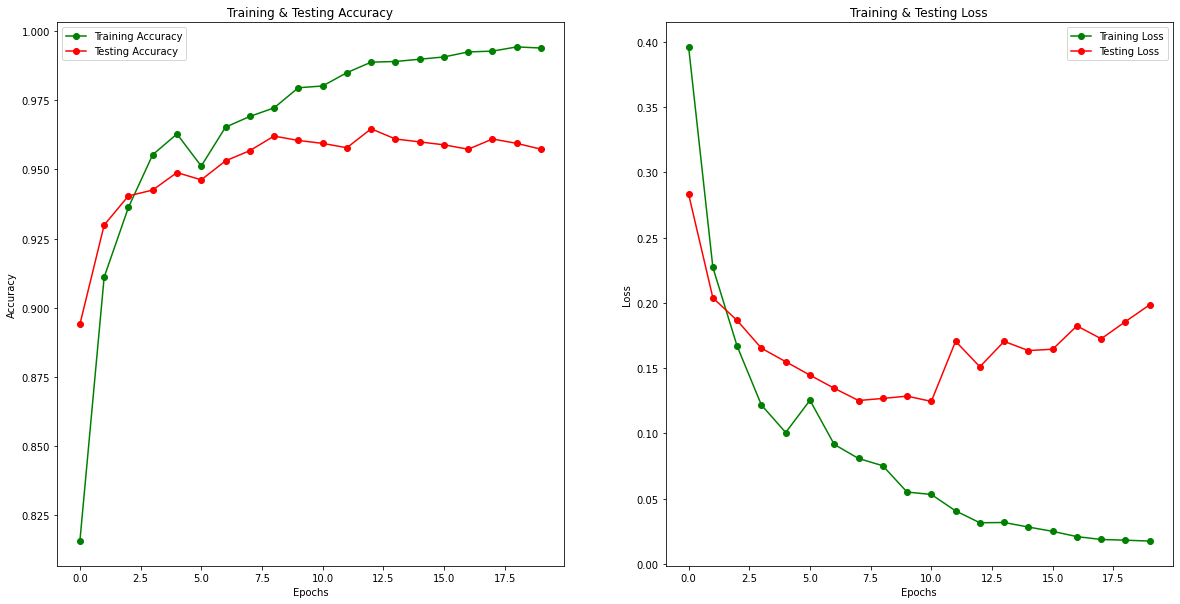

In [26]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Prédiction sur le test pour créer une matrice de confusion

In [27]:
pred = model.predict(X_test)

66/66 [==============================] - 17s 248ms/step


In [28]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.98      0.96      0.97      1264
        Fake       0.95      0.97      0.96       844

    accuracy                           0.97      2108
   macro avg       0.96      0.97      0.96      2108
weighted avg       0.97      0.97      0.97      2108



In [29]:
cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm

array([[1218,   46],
       [  27,  817]])

In [30]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

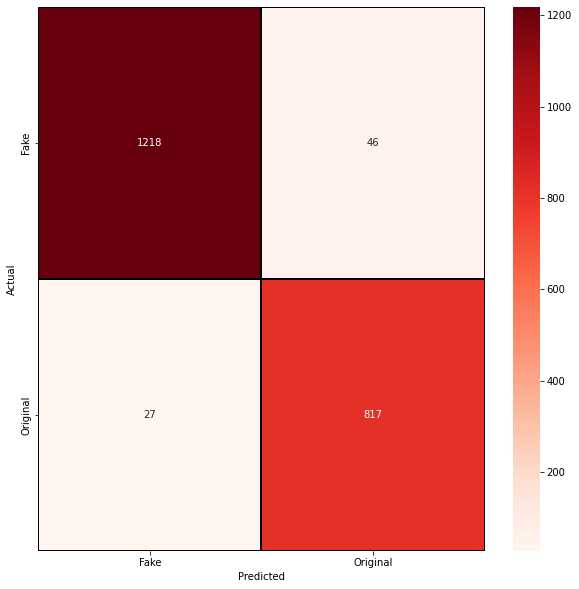

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")